# Hard spheres model development


First stage: Develop a CNN - based GAN to work with ordered point clouds.

## Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# Basic
from IPython.display import display

# For OS-agnostic paths
from pathlib import Path

# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from torch import nn
import pandas as pd
import numpy as np
sns.set_style("whitegrid")
from copy import deepcopy
import glob, json
from datetime import datetime
import torch
from torch import nn

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import DataLoader, Dataset, TensorDataset


from torchinfo import summary

import mlflow

%cd ..

from src.utils import load_raw_data
from src.plotting import plot_pointcloud, plot_sample_figures

%cd -

/Users/veikko/Documents/GitHub/hard-spheres
/Users/veikko/Documents/GitHub/hard-spheres/Notebooks


/Users/veikko/Documents/GitHub/hard-spheres/.venv/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Load data

In [3]:

phis = [0.84] # Add more phis here
path = Path("../data/raw/samples")

files, dataframe, metadata = load_raw_data(path, phi=phis)

dataframe

Number of Files found :  500


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

dataframe_scaled = pd.DataFrame(scaler.fit_transform(dataframe), columns=dataframe.columns)

dataframe_scaled.set_index(dataframe.index, inplace=True)

dataframe_scaled = dataframe_scaled.drop(columns=["class"]) # Redundant with r

### IMPORTANT: Order dataframe based on Xy coordinates

This is done to introduce the spatial relationship that a CNN can utilize.


In [298]:
_X = dataframe_scaled.copy()
_X["Xy"] = _X["x"] + _X["y"]
_X = _X.query("experiment=='phi-0.78'&sample=='sample-1'")

_X = _X.sort_values(by=["Xy", "x", "y"])

_X = _X.reset_index(drop=True)

_X


,x,y,r,Xy
0,-0.979956,-0.991787,-0.263158,-1.971743
1,-0.950463,-0.950672,-0.052632,-1.901135
2,-0.897144,-0.976755,0.263158,-1.873899
3,-0.974670,-0.894517,1.000000,-1.869187
4,-0.850507,-0.973282,-1.000000,-1.823789
...,...,...,...,...
1995,0.975533,0.850391,-0.684211,1.825923
1996,0.930619,0.918435,-0.894737,1.849055
1997,0.903379,0.963533,1.000000,1.866912
1998,0.982204,0.901241,0.473684,1.883446


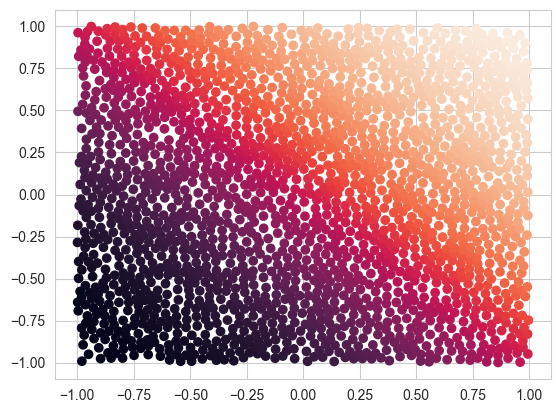

In [299]:
plt.scatter(x=_X.values[:,0], y=_X.values[:,1], c=_X.index)

This is better than not ordered, but can be problematic as values in the middle have a high probability of ending up with non-neighbouring samples.

However it is also a good experiment as if we observe that the corners behave better than the middle, we know we are on to something.

In [300]:
dataframe_scaled_ordered = dataframe_scaled.copy()
dataframe_scaled_ordered["Xy"] = dataframe_scaled_ordered["x"] + dataframe_scaled_ordered["y"]
dataframe_scaled_ordered = dataframe_scaled_ordered.sort_values(by=["experiment", "sample", "Xy"])
dataframe_scaled_ordered = dataframe_scaled_ordered.drop(columns=["Xy"])

## Build dataset

In [301]:

def get_descriptors(data, experiment, descriptors=["phi"]):
    
    descriptors = []

    phi = float(experiment.split("-")[-1])
    # Assume future data will have more dimensions
    phi = [[phi]] * 3
    descriptors.append(phi)

    # Convert to tensor
    descriptors = torch.tensor(descriptors, dtype=torch.float32)

    # For future compatibility, even if using a single descriptor, 
    # we will keep it as a 2D tensor
    if len(descriptors.shape) == 1:
        descriptors = descriptors.unsqueeze(1)
    
    # In the future descriptors may be tensors instead of scalars, include in design
    if len(descriptors.shape) == 2:
        descriptors = descriptors.unsqueeze(2)

    # descriptors = descriptors.flatten(start_dim=1)

    descriptors = descriptors.transpose(-1,-2)

    return descriptors


# Create a dataset
class HSDataset(TensorDataset):
    def __init__(self, dataframe, device="cpu", descriptor_list = ["phi"], synthetic_samples=False):
        print("Creating Dataset")
        print("Descriptor List: ", descriptor_list)
        # Split each experiment and sample into a separate sample

        descriptors = []
        samples = []

        for experiment, sample in dataframe.index.unique(): #TODO: Check if this is the right way to do it
            sample = torch.tensor(dataframe.loc[(experiment, sample),: ].copy().values, dtype=torch.float32, device=device)
            sample_descriptors = get_descriptors(sample, experiment, descriptors=descriptor_list)
            
            samples.append(sample.unsqueeze(0)) # We are creating a 3D tensor of 2D samples
            descriptors.append(sample_descriptors)
        
        if synthetic_samples:

            raise NotImplementedError("Synthetic samples not implemented yet.")

        

        self.x = torch.concat(descriptors) # Descriptors are the input.
        self.y = torch.concat(samples) # Sample point cloud is the target


    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        pointcloud = self.x[idx]
        descriptors = self.y[idx]
        return pointcloud, descriptors

dataset = HSDataset(dataframe_scaled_ordered, descriptor_list=["phi"])

Creating Dataset
Descriptor List:  ['phi']


In [302]:
print(dataset[:][0].shape)
print(dataset[:][1].shape)

torch.Size([400, 1, 3])
torch.Size([400, 2000, 3])


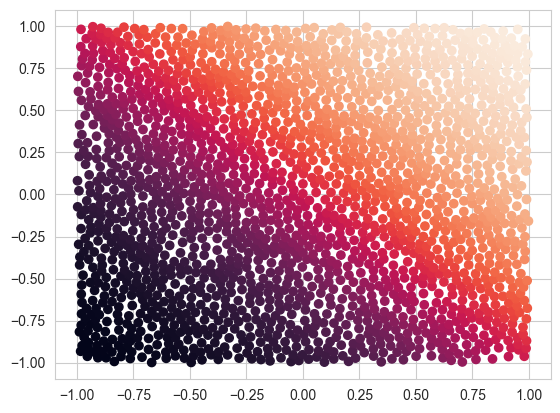

In [303]:
plt.scatter(x=dataset[2][1][:,0], y=dataset[2][1][:,1], c=list(range(len(dataset[2][1]))))


<Axes: >

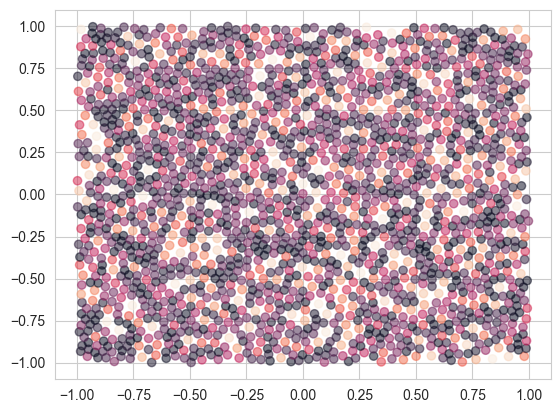

In [304]:
# Create a function that visualizes the point cloud

plot_pointcloud(dataset[2][1], plot_radius=False)

## Note: Samples are order invariant in the sample size dimension

<Axes: >

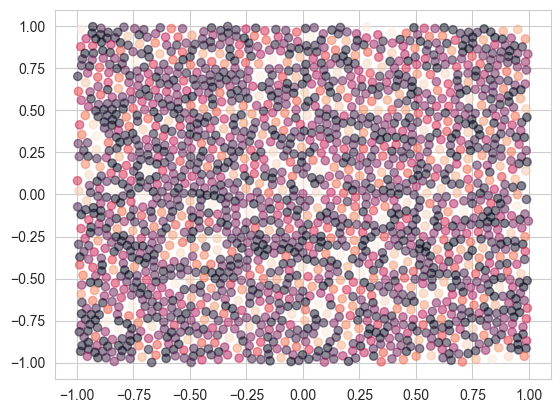

In [305]:
plot_pointcloud(reversed(dataset[2][1]), plot_radius=False)


## Check on x, y, r distributions

<Axes: xlabel='r', ylabel='Count'>

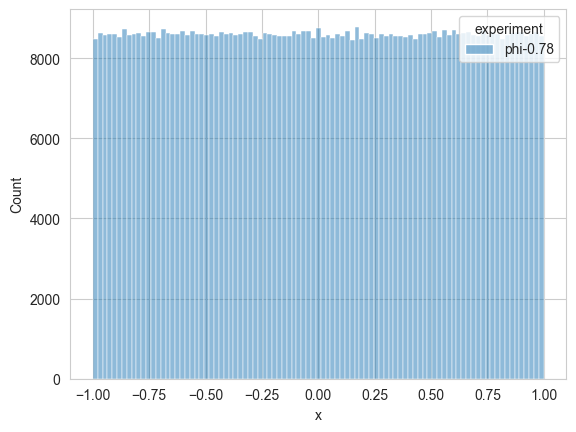

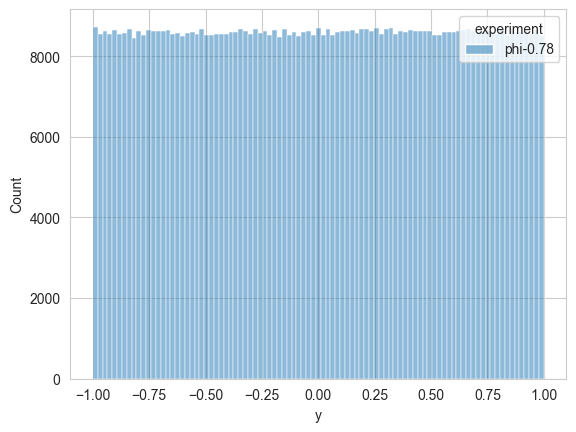

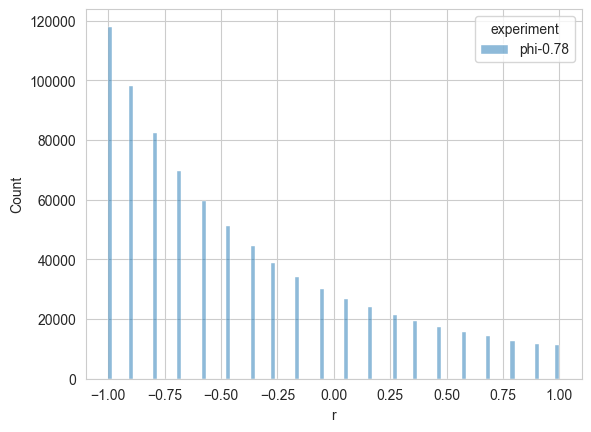

In [306]:
plt.figure()
sns.histplot(dataframe_scaled, x="x", hue="experiment", bins="auto")
plt.figure()
sns.histplot(dataframe_scaled, x="y", hue="experiment", bins="auto")
plt.figure()
sns.histplot(dataframe_scaled, x="r", hue="experiment", bins="auto")

x, y are uniform distributions

r seems to be an 1/x

# Create model

Create a GAN architecture, which creates point clouds $\hat{y}$ based on the descriptor(s) $\hat{X}$ and a random noise vector $\hat{z}$.

In [307]:
sample_x = dataset[0:32][0]#.transpose(-1,-2)
sample_y = dataset[0:32][1]

print(sample_x.shape, sample_y.shape)

torch.Size([32, 1, 3]) torch.Size([32, 2000, 3])


## Play around with models

(array([33., 29., 15.,  6.,  8.,  1.,  5.,  0.,  0.,  3.]),
 array([0.01037389, 0.1443074 , 0.27824091, 0.41217441, 0.54610792,
        0.68004143, 0.81397494, 0.94790845, 1.08184196, 1.21577547,
        1.34970898]),
 <BarContainer object of 10 artists>)

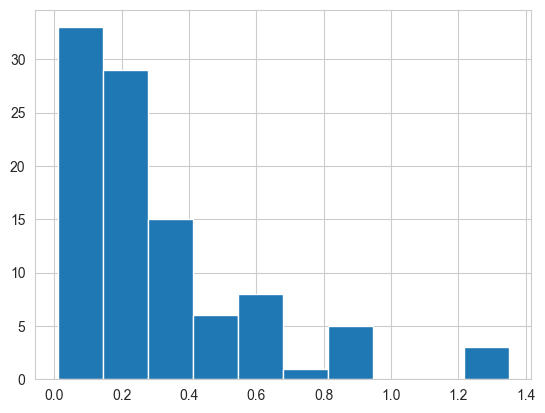

In [308]:
plt.hist(np.random.exponential(0.3, (100,1)))

In [309]:
output_max_samples = 2000
in_dim = 1 # We have a single descriptor

kernel_y = 64
cnn_layers = 3
latent_max_samples = output_max_samples + cnn_layers*kernel_y # We will add some padding to the latent space

latent_dim = 27 # This you can change
batch_size = sample_x.shape[0]
cnn_channels = 16

# Takes in the input descriptors and returns the output point cloud

desc2latent = nn.Sequential(
            # Input to latent space
            nn.ConvTranspose1d(in_dim, latent_dim//2, kernel_size=latent_max_samples//2, stride=1, padding=0, bias=True),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(latent_dim//2, latent_dim, kernel_size=latent_max_samples//2-1, stride=1, padding=0, bias=True),
            nn.LeakyReLU(0.2),
        )

# This is a good idea but difficult to implement with padding
# zx = torch.rand(batch_size, latent_max_samples, 1) # X is uniform
# zy = torch.rand(batch_size, latent_max_samples, 1) # Y is uniform
# # R is inverse exponential
# zr = torch.tensor(np.random.exponential(0.3, (batch_size, latent_max_samples, 1)), dtype=torch.float32)
# z = torch.cat([zx, zy, zr], dim=-1)

# Simple way
z = torch.rand(batch_size, latent_max_samples, latent_dim)

kernel_x = latent_dim // cnn_layers 

latent2pointcloud = nn.Sequential(
            nn.Conv2d(1, cnn_channels, kernel_size=(kernel_y+1, kernel_x), stride=1, padding=0, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(cnn_channels, cnn_channels, kernel_size=(kernel_y+1, kernel_x), stride=1, padding=0, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(cnn_channels, 1, kernel_size=(kernel_y+1, kernel_x), stride=1, padding=0, bias=False),
        )

print(r"X:", sample_x.shape)
print("Z:", z.shape)

x = sample_x
x = desc2latent(x)
print("mean:", x.mean(), x.min(), x.max())
x = x.transpose(-1,-2) 

print("Latent:", x.shape)
x = x + z
x = x.unsqueeze(1)

print("Latent random: ", x.shape)

x = latent2pointcloud(x)
x = x.squeeze(1)
print("Point cloud: ", x.shape)



# print("Latent reshaped:", desc2latent(sample_x_2d).reshape(batch_size, 1, -1, latent_dim).shape)
# print("Latent reshaped:", desc2latent(sample_x_2d).transpose(-1,-2).reshape(batch_size, 1, -1, latent_dim).shape)
# print("Output:", latent2pointcloud((desc2latent(sample_x_2d).reshape(batch_size, 1, -1, latent_dim))).shape)
# print(latent2pointcloud((desc2latent(sample_x_2d).transpose(-1,-2)*z)).shape)

# print(summary(latent2pointcloud,depth=1))
print(summary(desc2latent,depth=0))
print(summary(latent2pointcloud,depth=0))
# latent2pointcloud(desc2latent(sample_x)*z).transpose(-1,-2).shape


X: torch.Size([32, 1, 3])
Z: torch.Size([32, 2192, 27])
mean: tensor(0.0009, grad_fn=<MeanBackward0>) tensor(-0.0028, grad_fn=<MinBackward1>) tensor(0.0110, grad_fn=<MaxBackward1>)
Latent: torch.Size([32, 2192, 27])
Latent random:  torch.Size([32, 1, 2192, 27])
Point cloud:  torch.Size([32, 2000, 3])
Layer (type:depth-idx)                   Param #
Sequential                               398,633
Total params: 398,633
Trainable params: 398,633
Non-trainable params: 0
Layer (type:depth-idx)                   Param #
Sequential                               168,480
Total params: 168,480
Trainable params: 168,480
Non-trainable params: 0


In [359]:
class HSGenerator(nn.Module):
    def __init__(self, in_dim, latent_dim=27, output_max_samples=2000, cnn_channels = 16):
        super().__init__()
        # Takes in the input descriptors and returns the output point cloud

        assert latent_dim % 3 == 0, "Latent dim needs to be multiples of 3"

        # TODO: Move these to config
        # Maps descriptors to latent space
        in_dim = 1 # We have a single descriptor

        kernel_y = 64
        cnn_layers = 3
        

        latent_max_samples = output_max_samples + cnn_layers*kernel_y # We will add some padding to the latent space
        kernel_x = latent_dim // cnn_layers 

        # Takes in the input descriptors and returns the output point cloud

        self.desc2latent = nn.Sequential(
                    # Input to latent space
                    nn.ConvTranspose1d(in_dim, latent_dim//2, kernel_size=latent_max_samples//2, stride=1, padding=0, bias=True),
                    nn.ConvTranspose1d(latent_dim//2, latent_dim, kernel_size=latent_max_samples//2-1, stride=1, padding=0, bias=True),
                )

        self.latent2pointcloud = nn.Sequential(
            nn.Conv2d(1, cnn_channels, kernel_size=(kernel_y+1, kernel_x), stride=1, padding=0, bias=True),
            nn.Conv2d(cnn_channels, cnn_channels, kernel_size=(kernel_y+1, kernel_x), stride=1, padding=0, bias=True),
            nn.Conv2d(cnn_channels, 1, kernel_size=(kernel_y+1, kernel_x), stride=1, padding=0, bias=True),
        )
        

        self.in_dim = in_dim
        self.latent_dim = latent_dim
        self.output_max_samples = output_max_samples
        self.latent_max_samples = latent_max_samples
        self.latent_dim = latent_dim
    
    def get_z(self,batch_size):
        return torch.rand(batch_size, self.latent_max_samples, self.latent_dim)

    def forward(self, d: torch.tensor):

        # Input d: Batch x Descriptors x 1 # TODO: In the future a single descriptor will be a 1D tensor, changing dimensions to Batch x Descriptors x NFeatures
        # Output: Batch x Samples x 4 (class, x, y, r) 
        batch_size = d.shape[0]
        
        z = self.get_z(batch_size)

        x = d
        x = (self.desc2latent(x).transpose(-1,-2) + z) / 2
        x = self.latent2pointcloud(x.unsqueeze(1)).squeeze(1)
        return torch.clip(x, -1, 1)

print(HSGenerator(output_max_samples=dataset.y.shape[1], latent_dim=27, in_dim=3)(sample_x).shape)

summary(
    HSGenerator(output_max_samples=dataset.y.shape[1], latent_dim=9, in_dim=3, cnn_channels=4), input_data=sample_x
    )


torch.Size([32, 2000, 3])


Layer (type:depth-idx)                   Output Shape              Param #
HSGenerator                              [32, 2000, 3]             --
├─Sequential: 1-1                        [32, 9, 2192]             --
│    └─ConvTranspose1d: 2-1              [32, 4, 1098]             4,388
│    └─ConvTranspose1d: 2-2              [32, 9, 2192]             39,429
├─Sequential: 1-2                        [32, 1, 2000, 3]          --
│    └─Conv2d: 2-3                       [32, 4, 2128, 7]          784
│    └─Conv2d: 2-4                       [32, 4, 2064, 5]          3,124
│    └─Conv2d: 2-5                       [32, 1, 2000, 3]          781
Total params: 48,506
Trainable params: 48,506
Non-trainable params: 0
Total mult-adds (G): 4.48
Input size (MB): 0.00
Forward/backward pass size (MB): 33.53
Params size (MB): 0.19
Estimated Total Size (MB): 33.73

<Axes: >

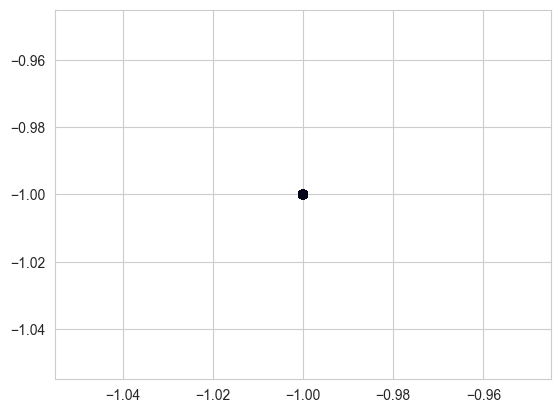

In [374]:
# sample_pred_y = HSGenerator(output_max_samples=dataset.y.shape[1], latent_dim=27, in_dim=3)(sample_x).detach()
sample_pred_y = gan.generator(sample_x).detach()

plot_pointcloud(sample_pred_y[0,:,:], plot_radius=False)

In [361]:
class HSDiscriminator(nn.Module):
    def __init__(self, channels_img=4, features_d=12):
        # Discriminator takes in the point cloud and returns a list of predicted labels (real/fake) 
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(
                channels_img, features_d//2, kernel_size=(64,2), stride=(2,1)
            ),  # 32x32
            nn.LeakyReLU(0.2),
            self._block(features_d//2, features_d, kernel_size=(32,2), stride=(3,1)),
            self._block(features_d, features_d, kernel_size=(16,2), stride=(1,1)),
            nn.Conv2d(features_d, 1, kernel_size=(4,2)),  # 1x1
            nn.Flatten(),
            nn.MaxPool1d(5),
            nn.Linear(178,32),
            nn.LeakyReLU(0.2),
            nn.Linear(32,1),
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride=stride, padding=1, bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x.unsqueeze(1))

print(sample_x.shape)
print(sample_y.shape)
HSDiscriminator(channels_img=1, features_d=4)(sample_y).shape

summary(HSDiscriminator(channels_img=1, features_d=32), input_data=sample_y, depth=2)

torch.Size([32, 1, 3])
torch.Size([32, 2000, 3])


Layer (type:depth-idx)                   Output Shape              Param #
HSDiscriminator                          [32, 1]                   --
├─Sequential: 1-1                        [32, 1]                   --
│    └─Conv2d: 2-1                       [32, 16, 969, 2]          2,064
│    └─LeakyReLU: 2-2                    [32, 16, 969, 2]          --
│    └─Sequential: 2-3                   [32, 32, 314, 3]          32,832
│    └─Sequential: 2-4                   [32, 32, 301, 4]          32,832
│    └─Conv2d: 2-5                       [32, 1, 298, 3]           257
│    └─Flatten: 2-6                      [32, 894]                 --
│    └─MaxPool1d: 2-7                    [32, 178]                 --
│    └─Linear: 2-8                       [32, 32]                  5,728
│    └─LeakyReLU: 2-9                    [32, 32]                  --
│    └─Linear: 2-10                      [32, 1]                   33
│    └─Sigmoid: 2-11                     [32, 1]                   --


In [362]:
# if detect_bad_gradients:
#             with autograd.detect_anomaly():
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels, weights)  # Compute RMSE from MSE
#                 loss.backward()
#         else:
#             outputs = model(inputs)
#             loss = criterion(outputs, labels, weights)  # Compute RMSE from MSE
#             loss.backward()
#         grad_norm = torch.nn.utils.clip_grad_norm_(
#             model.parameters(), 50
#         )  # Clip gradients

In [379]:
from tqdm import tqdm
from torch import autograd

# Create a GAN class that takes in the generator and discriminator, and the training data
# The GAN class will be responsible for training the generator and discriminator
# The GAN should train the generator to generate images of the digit that is fed as the input

class GAN(nn.Module):
    def __init__(self, generator, discriminator, trainset, testset, device='cpu', batch_size=32, descriptor_loss=False):
        super(GAN, self).__init__()
        self.trainset = trainset
        self.testset = testset
        self.device = device
        self.batch_size = batch_size

        self.generator = generator.to(device)
        self.discriminator = discriminator.to(device)
        self.criterion = nn.BCELoss()
        self.d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=0.0002, weight_decay=0.00)
        self.g_optimizer = torch.optim.Adam(self.generator.parameters(), lr=0.0002, weight_decay=0.00)

        if descriptor_loss:
            self.descriptor_criterion = nn.RMSELoss()
            # TODO: Implement

    def train_n_epochs(self, epochs, batch_size=32):
        print(f'Starting...\nTime: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')

        dataloader = DataLoader(self.trainset, batch_size=batch_size, shuffle=True)


        for epoch in range(epochs):
            self._train_epoch(epoch, batch_size=batch_size, dataloader=dataloader)
        
    def _physical_loss(self, real_images, fake_images):
        # Loss based on the physical properties of the point cloud
        
        # Loss based on sum of radiuses
        real_radius = real_images[:,2].mean()
        fake_radius = fake_images[:,2].mean()
        radius_loss = torch.abs(real_radius - fake_radius)

        # Loss based on mean and variance of x and y
        real_x_mean = real_images[:,0].mean()
        fake_x_mean = fake_images[:,0].mean()
        x_mean_loss = torch.abs(real_x_mean - fake_x_mean)

        real_x_var = real_images[:,0].var()
        fake_x_var = fake_images[:,0].var()
        x_var_loss = torch.abs(real_x_var - fake_x_var)

        real_y_mean = real_images[:,1].mean()
        fake_y_mean = fake_images[:,1].mean()
        y_mean_loss = torch.abs(real_y_mean - fake_y_mean)

        real_y_var = real_images[:,1].var()
        fake_y_var = fake_images[:,1].var()
        y_var_loss = torch.abs(real_y_var - fake_y_var)

        # TODO Add more physical properties, phi etc.
        loss = (radius_loss + x_mean_loss + x_var_loss + y_mean_loss + y_var_loss) / 5
        return loss


    def _train_epoch(self, epoch, batch_size=32, dataloader=None):

        if dataloader is None:
            dataloader = DataLoader(self.trainset, batch_size=batch_size, shuffle=True)

        self.generator.train()
        self.discriminator.train()

        mean_loss_d = 0
        mean_loss_g = 0

        d_loss = torch.tensor([0])
        
        for descriptors, real_images in tqdm(dataloader):
            real_images = real_images.to(self.device)
            descriptors = descriptors.to(self.device)

            real_labels = torch.ones(real_images.size(0), 1).to(self.device)
            fake_labels = torch.zeros(real_images.size(0), 1).to(self.device)

            # Train the discriminator       
            self.d_optimizer.zero_grad()

            real_outputs = self.discriminator(real_images)
            d_loss_real = self.criterion(real_outputs, real_labels)
            d_loss_real.backward()

            fake_images = self.generator(descriptors)
            fake_outputs = self.discriminator(fake_images)
            d_loss_fake = self.criterion(fake_outputs, fake_labels)
            d_loss_fake.backward()

            d_loss = d_loss_real + d_loss_fake

            # d_grad_norm = torch.nn.utils.clip_grad_norm_(
            # self.discriminator.parameters(), 50, error_if_nonfinite=True
            # )  # Clip gradients
            self.d_optimizer.step() 
            mean_loss_d += d_loss.item()

            # Train the generator
            self.g_optimizer.zero_grad()

            fake_images = self.generator(descriptors)
            fake_outputs = self.discriminator(fake_images)
            g_loss_gan = self.criterion(fake_outputs, real_labels) # We want the generator to generate images that the discriminator thinks are real
            g_loss_physical = self._physical_loss(real_images, fake_images) 

            g_loss = g_loss_gan # g_loss_physical
            g_loss.backward()

            # g_grad_norm = torch.nn.utils.clip_grad_norm_(
            # self.generator.parameters(), 50, error_if_nonfinite=True
            # )  # Clip gradients
            self.g_optimizer.step()

            mean_loss_g += g_loss.item()

        print(f'Time: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}, Epoch {epoch}, D loss: {d_loss.item()}, G_GAN loss: {g_loss_gan.item()}, G_P loss: {g_loss_physical.item()}')

        mean_loss_d /= len(self.trainset)
        mean_loss_g /= len(self.trainset)

        return mean_loss_d, mean_loss_g

    def generate(self, input):
        self.generator.eval()
        return self.generator(input.to(self.device)).detach().cpu()


## Train the model

In [350]:
test_frac = 0.2

trainset, testset = torch.utils.data.random_split(dataset, [1-test_frac, test_frac])

In [380]:
generator = HSGenerator(output_max_samples=dataset.y.shape[1], in_dim=3, latent_dim=9, cnn_channels=3)
discriminator = HSDiscriminator(channels_img=1, features_d=4)

print(summary(generator, input_data=sample_x, depth=1))
print(summary(discriminator, input_data=sample_y, depth=1))

gan = GAN(generator, discriminator, trainset, testset, device='cpu', batch_size=64)


Layer (type:depth-idx)                   Output Shape              Param #
HSGenerator                              [32, 2000, 3]             --
├─Sequential: 1-1                        [32, 9, 2192]             43,817
├─Sequential: 1-2                        [32, 1, 2000, 3]          2,932
Total params: 46,749
Trainable params: 46,749
Non-trainable params: 0
Total mult-adds (G): 3.89
Input size (MB): 0.00
Forward/backward pass size (MB): 27.08
Params size (MB): 0.19
Estimated Total Size (MB): 27.27
Layer (type:depth-idx)                   Output Shape              Param #
HSDiscriminator                          [32, 1]                   --
├─Sequential: 1-1                        [32, 1]                   7,092
Total params: 7,092
Trainable params: 7,092
Non-trainable params: 0
Total mult-adds (M): 52.29
Input size (MB): 9.60
Forward/backward pass size (MB): 5.62
Params size (MB): 0.03
Estimated Total Size (MB): 15.25


In [383]:
gan.train_n_epochs(10,batch_size=64)

Starting...
Time: 2024-06-06 00:19:58


100%|██████████| 5/5 [00:25<00:00,  5.09s/it]


Time: 2024-06-06 00:20:24, Epoch 0, D loss: 1.3771090507507324, G_GAN loss: 0.7673231363296509, G_P loss: 0.5012547969818115


100%|██████████| 5/5 [00:24<00:00,  4.99s/it]


Time: 2024-06-06 00:20:49, Epoch 1, D loss: 1.3633074760437012, G_GAN loss: 0.7912565469741821, G_P loss: 0.46155834197998047


100%|██████████| 5/5 [00:23<00:00,  4.66s/it]


Time: 2024-06-06 00:21:12, Epoch 2, D loss: 1.405247688293457, G_GAN loss: 0.7707347273826599, G_P loss: 0.38291025161743164


100%|██████████| 5/5 [00:23<00:00,  4.71s/it]


Time: 2024-06-06 00:21:36, Epoch 3, D loss: 1.3340766429901123, G_GAN loss: 0.9097992181777954, G_P loss: 0.14778205752372742


100%|██████████| 5/5 [00:23<00:00,  4.71s/it]


Time: 2024-06-06 00:21:59, Epoch 4, D loss: 1.1668152809143066, G_GAN loss: 1.1738877296447754, G_P loss: 0.17881138622760773


100%|██████████| 5/5 [00:23<00:00,  4.71s/it]


Time: 2024-06-06 00:22:23, Epoch 5, D loss: 1.1179287433624268, G_GAN loss: 1.3329403400421143, G_P loss: 0.11444783210754395


100%|██████████| 5/5 [00:23<00:00,  4.65s/it]


Time: 2024-06-06 00:22:46, Epoch 6, D loss: 1.0366942882537842, G_GAN loss: 1.4552217721939087, G_P loss: 0.15741540491580963


100%|██████████| 5/5 [00:25<00:00,  5.01s/it]


Time: 2024-06-06 00:23:11, Epoch 7, D loss: 0.9804320335388184, G_GAN loss: 1.4007874727249146, G_P loss: 0.28972071409225464


100%|██████████| 5/5 [00:23<00:00,  4.67s/it]


Time: 2024-06-06 00:23:34, Epoch 8, D loss: 1.0521483421325684, G_GAN loss: 1.0602006912231445, G_P loss: 0.42089390754699707


100%|██████████| 5/5 [00:22<00:00,  4.57s/it]

Time: 2024-06-06 00:23:57, Epoch 9, D loss: 1.0194652080535889, G_GAN loss: 0.967353343963623, G_P loss: 0.5286903977394104


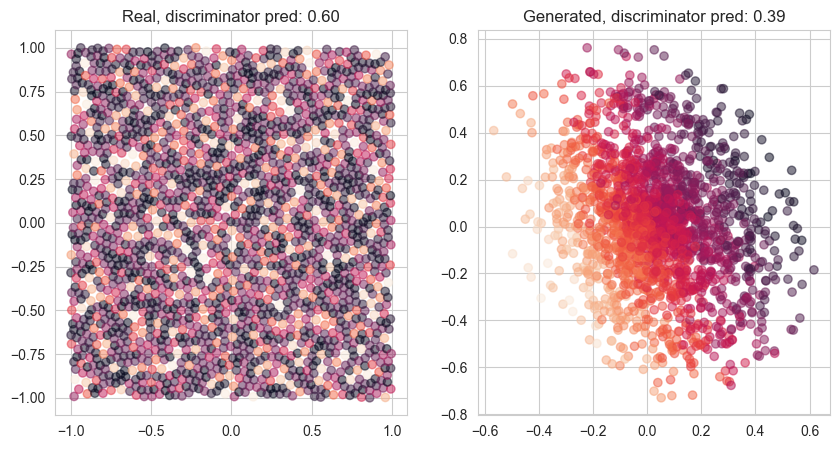

In [386]:
# Check on the created figures

plot_sample_figures(generator, discriminator, dataset, n=2, plot_radius=False)

<Axes: >

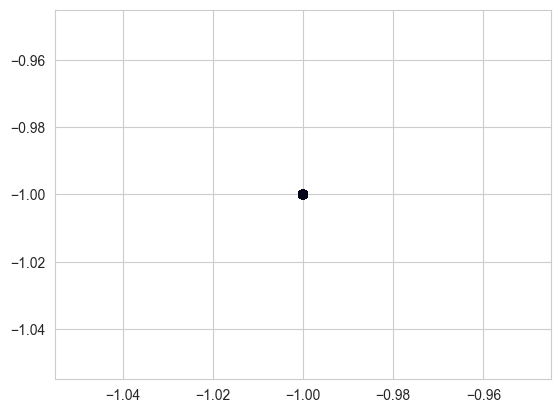

In [378]:
sample_pred_y = gan.generator(sample_x).detach()

plot_pointcloud(sample_pred_y[0,:,:], plot_radius=False)

In [ ]:
# Check physical feasibility of the generated point clouds

# Start with summing overlapping areas

def count_overlaps(xs, ys, rs):
    # Count the number of overlaps in the pointcloud
    # Overlapping areas are areas where the radius of a point is larger than the distance to the nearest point minus the radius of the nearest point

    # n_points = pointclouds.shape[0]
    # overlaps = 0

    # distances = torch.cdist(pointclouds, pointclouds)
    pass
    

   


# Check if the sum of overlapping areas is correct
# pointclouds = dataset[:][1]
# count_overlaps(pointclouds)


# Profile model performance for computational bottlenecks

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        generator(sample_x)

    # print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))


STAGE:2024-05-18 18:32:50 53521:4743870 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-05-18 18:32:50 53521:4743870 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-05-18 18:32:50 53521:4743870 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [ ]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))

--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                 model_inference        41.71%       5.928ms       100.00%      14.214ms      14.214ms             1  
               aten::convolution         0.27%      38.000us        30.12%       4.281ms       2.140ms             2  
              aten::_convolution        18.66%       2.652ms        29.85%       4.243ms       2.122ms             2  
          aten::conv_transpose1d         0.04%       5.000us        20.88%       2.968ms       2.968ms             1  
                     aten::randn         5.29%     752.000us        17.73%       2.520ms       2.520ms             1  
                   aten::normal_        12.40%  

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        discriminator(sample_y)

    # print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))


STAGE:2024-05-18 18:33:05 53521:4743870 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-05-18 18:33:05 53521:4743870 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-05-18 18:33:05 53521:4743870 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [ ]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference        26.75%       4.685ms       100.00%      17.513ms      17.513ms             1  
                     aten::conv2d         0.22%      39.000us        58.93%      10.321ms       2.064ms             5  
                aten::convolution         0.50%      88.000us        58.71%      10.282ms       2.056ms             5  
               aten::_convolution         0.36%      63.000us        58.21%      10.194ms       2.039ms             5  
         aten::mkldnn_convolution        57.36%      10.045ms        57.85%      10.131ms       2.026ms             5  
                 aten::leaky_relu       

### OPEN QUESTIONS

- What to do with the metadata?
- Class and radius are redundant. Is the real physical measure numerical or categorical / quantified? 

In [45]:
metadata.round(5).drop_duplicates()

,,N,L,A
experiment,sample,,,
phi-0.74,sample-245,2000,46.88709,1626.81571
phi-0.72,sample-245,2000,47.53384,1626.81571
phi-0.70,sample-245,2000,48.20812,1626.81571
